<a href="https://colab.research.google.com/github/LinusTC/MLP-CW3/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cotton Leaf Disease Classification

In [1]:
'''! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle\ API/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json'''

"! pip install kaggle\nfrom google.colab import drive\ndrive.mount('/content/drive')\n! mkdir ~/.kaggle\n!cp /content/drive/MyDrive/Kaggle\\ API/kaggle.json ~/.kaggle/kaggle.json\n! chmod 600 ~/.kaggle/kaggle.json"

## 1.0 Imports

In [2]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import plotly.graph_objects as go
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### 1.1 Kaggle Imports

In [3]:
'''import kaggle
import kagglehub

# Download latest version
path = "/kaggle/input/cotton-leaf-disease-dataset/cotton"

print("Path to dataset files:", path)'''

'import kaggle\nimport kagglehub\n\n# Download latest version\npath = "/kaggle/input/cotton-leaf-disease-dataset/cotton"\n\nprint("Path to dataset files:", path)'

In [4]:
'''import os
print(os.listdir("Cotton Plant Images"))'''
path = "/kaggle/input/cotton-leaf-disease-dataset/cotton"

## 2. Load Data

In [5]:
transform = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(350),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

train_size = len(dataset) // 2
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffle for testing

labels_map = {
    0: "bacterial_blight",
    1: "curl_virus",
    2: "fussarium_wilt",
    3: "healthy",
}

image, label = train_dataset[0]
image.size()

torch.Size([3, 350, 350])

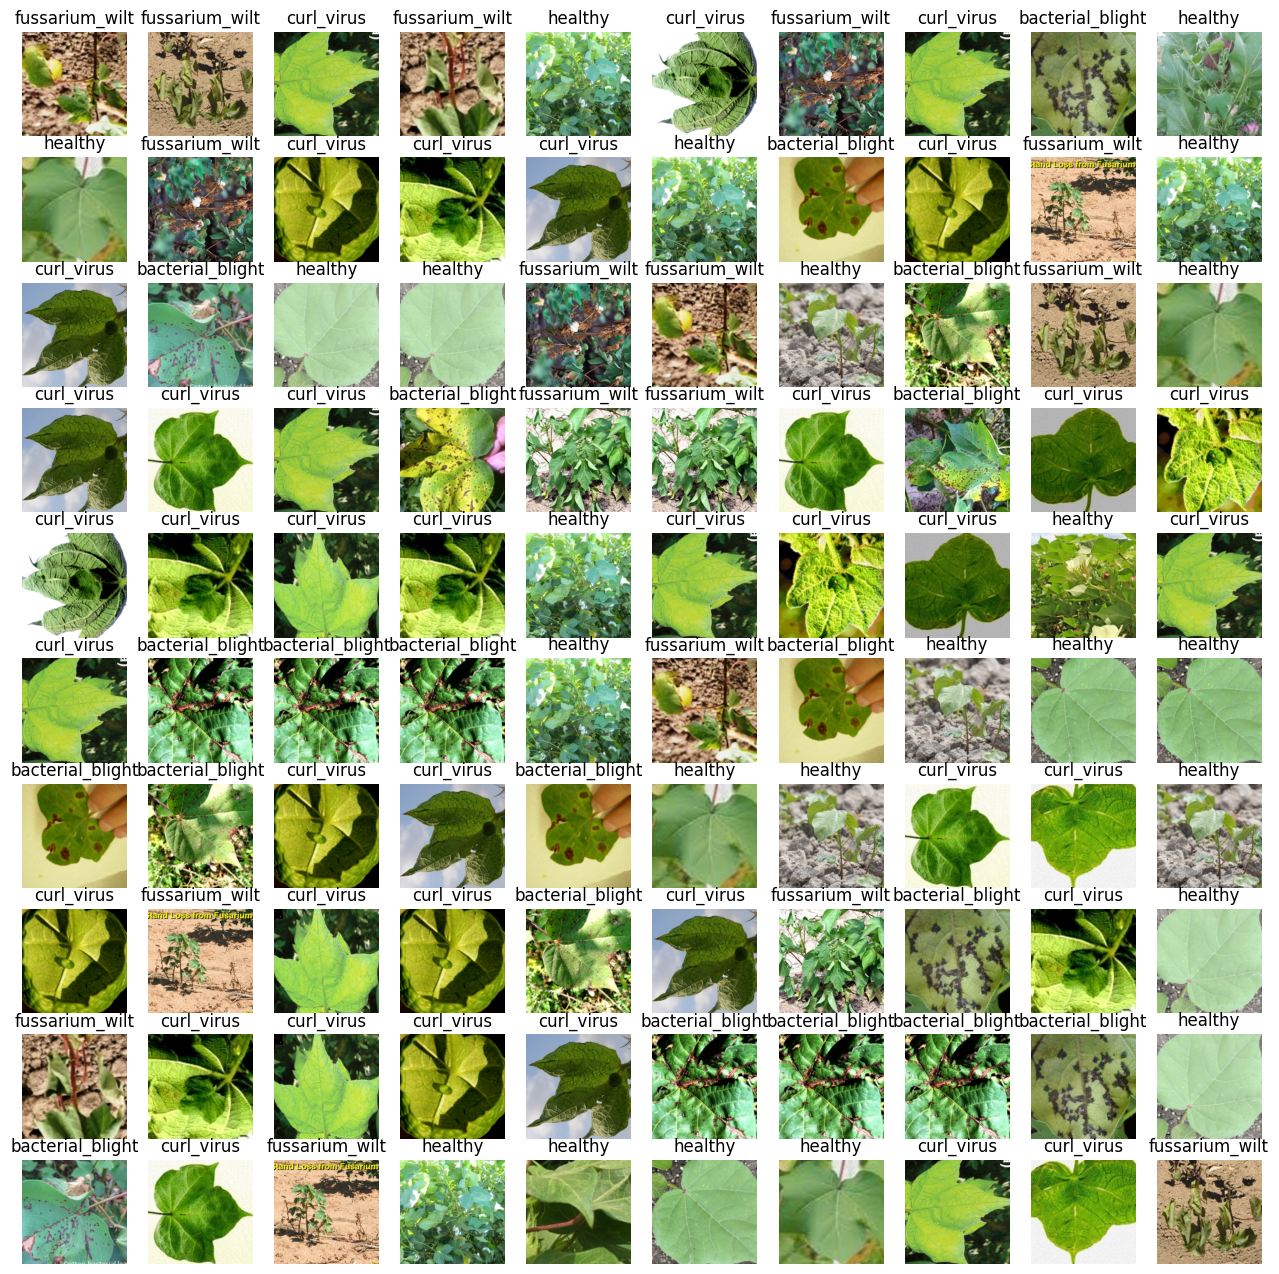

In [6]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display Sample Images
figure = plt.figure(figsize=(16, 16))
cols, rows = 10, 10

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")

    img = img.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for display
    plt.imshow(img)

plt.show()


## 3. Filter

## 4. Image Classification

### 4.1 Initial Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork (nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 7) #(32, 344, 344)
        self.pool = nn.MaxPool2d (2, 2) #(32, 172, 172)
        self.conv2 = nn.Conv2d(32, 64, 7) #(64, 166, 166) #(64, 83, 83)
        self.conv3 = nn.Conv2d (64, 128, 7) # Output: (256, 76, 76) #(128, 38, 38)
        self.conv4 = nn.Conv2d(128, 256, 7) #(256, 32, 32) #(256, 16, 16)

        self.fc1 = nn.Linear(256 * 16 * 16, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [ ]:
training_net = NeuralNetwork()

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(training_net.parameters(), lr=0.001)

#### Inital Model: Training and Validation

In [ ]:
num_epochs = 50

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training_net.to(device)

# Track loss and accuracy
epoch_losses = []
epoch_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    training_net.train()
    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (inputs, labels) in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = training_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        train_loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples
    epoch_losses.append(avg_train_loss)
    epoch_accuracies.append(train_accuracy)

    # Validation
    training_net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:  # Assuming you have a `val_loader`
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = training_net(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.6f} | Train Acc: {train_accuracy*100:.2f}% | "
          f"Val Loss: {avg_val_loss:.6f} | Val Acc: {val_accuracy*100:.2f}%")

train_loop.close()


In [ ]:
torch.save(training_net.state_dict(), 'trained_net.pth')

In [ ]:
import plotly.graph_objects as go

# --- Plot Training Loss ---
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)),
    y=epoch_losses,
    mode='lines+markers',
    name='Training Loss'
))
fig_loss.update_layout(
    title='Training Loss Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    template='plotly_dark'
)
fig_loss.show()

# --- Plot Training Accuracy ---
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)),
    y=[acc * 100 for acc in epoch_accuracies],  # convert to %
    mode='lines+markers',
    name='Training Accuracy'
))
fig_acc.update_layout(
    title='Training Accuracy Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Accuracy (%)',
    template='plotly_dark'
)
fig_acc.show()


#### Inital Model: Testing

In [ ]:
test_net = NeuralNetwork()

test_net.load_state_dict(torch.load('trained_net.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_net.to(device)

test_net.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


### 4.2 Nat's Model

In [ ]:
class BNNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduces to (batch_size, channels, 1, 1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.pool(self.conv4(x))

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

### 4.3 VGG16 Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = self.global_avg_pool(out)
        out = self.classifier(out)
        return out

In [8]:
num_classes = 4
num_epochs = 50
batch_size = 32
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 1e-4, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

#### VGG16: Training and Validation

In [9]:
torch.cuda.empty_cache()

# Tracking lists
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

total_step = len(train_loader)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loop = tqdm(enumerate(train_loader), total=total_step, desc=f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    
    for i, (images, labels) in train_loop:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loop.set_postfix(loss=loss.item())
    
    avg_train_loss = running_loss / total_step
    train_losses.append(avg_train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        validation_loop = tqdm(test_loader, desc='Validating')
        for images, labels in validation_loop:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            del images, labels, outputs

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Train Loss: {avg_train_loss:.4f}')
    scheduler.step(val_accuracy)

Validating: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch 1: Train Acc: 32.75%, Val Acc: 24.80%, Val Loss: 1.3920, Train Loss: 1.3175


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 2: Train Acc: 53.33%, Val Acc: 53.10%, Val Loss: 1.2127, Train Loss: 1.1574


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 3: Train Acc: 61.52%, Val Acc: 72.05%, Val Loss: 0.9851, Train Loss: 1.0692


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 4: Train Acc: 67.84%, Val Acc: 72.16%, Val Loss: 0.9182, Train Loss: 0.9847


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


Epoch 5: Train Acc: 70.06%, Val Acc: 76.49%, Val Loss: 0.8520, Train Loss: 0.9208


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 6: Train Acc: 73.80%, Val Acc: 80.12%, Val Loss: 0.7921, Train Loss: 0.8678


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 7: Train Acc: 77.78%, Val Acc: 80.94%, Val Loss: 0.7352, Train Loss: 0.8181


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch 8: Train Acc: 79.30%, Val Acc: 82.92%, Val Loss: 0.6924, Train Loss: 0.7617


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Epoch 9: Train Acc: 78.71%, Val Acc: 83.74%, Val Loss: 0.6518, Train Loss: 0.7123


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 10: Train Acc: 81.05%, Val Acc: 84.68%, Val Loss: 0.6119, Train Loss: 0.6763


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


Epoch 11: Train Acc: 81.40%, Val Acc: 84.21%, Val Loss: 0.5829, Train Loss: 0.6448


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 12: Train Acc: 82.81%, Val Acc: 83.16%, Val Loss: 0.5678, Train Loss: 0.5952


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 13: Train Acc: 84.09%, Val Acc: 82.69%, Val Loss: 0.5388, Train Loss: 0.5751


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 14: Train Acc: 84.91%, Val Acc: 80.58%, Val Loss: 0.5623, Train Loss: 0.5503


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 15: Train Acc: 82.69%, Val Acc: 85.15%, Val Loss: 0.4885, Train Loss: 0.5584


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 16: Train Acc: 86.32%, Val Acc: 84.91%, Val Loss: 0.4843, Train Loss: 0.5140


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 17: Train Acc: 85.61%, Val Acc: 84.09%, Val Loss: 0.4784, Train Loss: 0.4932


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 18: Train Acc: 86.55%, Val Acc: 85.03%, Val Loss: 0.4589, Train Loss: 0.4706


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 19: Train Acc: 85.73%, Val Acc: 86.20%, Val Loss: 0.4411, Train Loss: 0.4729


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 20: Train Acc: 87.49%, Val Acc: 87.49%, Val Loss: 0.4340, Train Loss: 0.4435


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 21: Train Acc: 88.19%, Val Acc: 88.77%, Val Loss: 0.4128, Train Loss: 0.4317


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 22: Train Acc: 86.90%, Val Acc: 87.60%, Val Loss: 0.4135, Train Loss: 0.4355


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Epoch 23: Train Acc: 87.84%, Val Acc: 87.84%, Val Loss: 0.4123, Train Loss: 0.4330


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 24: Train Acc: 87.95%, Val Acc: 89.94%, Val Loss: 0.3905, Train Loss: 0.4222


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 25: Train Acc: 89.01%, Val Acc: 89.01%, Val Loss: 0.3880, Train Loss: 0.3861


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 26: Train Acc: 89.82%, Val Acc: 89.36%, Val Loss: 0.3693, Train Loss: 0.3831


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 27: Train Acc: 90.53%, Val Acc: 88.89%, Val Loss: 0.3716, Train Loss: 0.3710


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 28: Train Acc: 89.94%, Val Acc: 89.82%, Val Loss: 0.3514, Train Loss: 0.3716


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 29: Train Acc: 90.76%, Val Acc: 90.29%, Val Loss: 0.3423, Train Loss: 0.3539


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 30: Train Acc: 92.16%, Val Acc: 90.76%, Val Loss: 0.3342, Train Loss: 0.3300


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


Epoch 31: Train Acc: 91.35%, Val Acc: 90.76%, Val Loss: 0.3327, Train Loss: 0.3472


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


Epoch 32: Train Acc: 91.46%, Val Acc: 91.81%, Val Loss: 0.3334, Train Loss: 0.3342


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 33: Train Acc: 91.35%, Val Acc: 91.58%, Val Loss: 0.3248, Train Loss: 0.3392


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 34: Train Acc: 91.46%, Val Acc: 92.16%, Val Loss: 0.3165, Train Loss: 0.3224


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 35: Train Acc: 89.94%, Val Acc: 90.76%, Val Loss: 0.3228, Train Loss: 0.3327


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


Epoch 36: Train Acc: 91.35%, Val Acc: 91.58%, Val Loss: 0.3110, Train Loss: 0.3253


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Epoch 37: Train Acc: 91.93%, Val Acc: 91.58%, Val Loss: 0.3081, Train Loss: 0.3167


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 38: Train Acc: 91.58%, Val Acc: 92.98%, Val Loss: 0.2953, Train Loss: 0.3235


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 39: Train Acc: 93.33%, Val Acc: 91.35%, Val Loss: 0.3008, Train Loss: 0.2962


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 40: Train Acc: 92.40%, Val Acc: 92.98%, Val Loss: 0.2937, Train Loss: 0.2969


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Epoch 41: Train Acc: 93.10%, Val Acc: 92.98%, Val Loss: 0.2972, Train Loss: 0.3007


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 42: Train Acc: 94.27%, Val Acc: 93.22%, Val Loss: 0.2819, Train Loss: 0.2777


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 43: Train Acc: 93.92%, Val Acc: 92.51%, Val Loss: 0.2943, Train Loss: 0.2802


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 44: Train Acc: 93.57%, Val Acc: 93.57%, Val Loss: 0.2794, Train Loss: 0.2772


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 45: Train Acc: 93.92%, Val Acc: 93.33%, Val Loss: 0.2708, Train Loss: 0.2638


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 46: Train Acc: 92.05%, Val Acc: 92.87%, Val Loss: 0.2742, Train Loss: 0.2938


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


Epoch 47: Train Acc: 93.10%, Val Acc: 93.33%, Val Loss: 0.2759, Train Loss: 0.2780


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


Epoch 48: Train Acc: 94.39%, Val Acc: 92.98%, Val Loss: 0.2826, Train Loss: 0.2742


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


Epoch 49: Train Acc: 94.04%, Val Acc: 93.22%, Val Loss: 0.2699, Train Loss: 0.2532


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]

Epoch 50: Train Acc: 93.57%, Val Acc: 93.92%, Val Loss: 0.2629, Train Loss: 0.2553


In [10]:
torch.save(model.state_dict(), 'vgg16_model.pth')

In [12]:
# Plot Losses
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=train_losses, mode='lines+markers', name='Training Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=val_losses, mode='lines+markers', name='Validation Loss'))
fig_loss.update_layout(
    title='Training & Validation Loss Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss',
)
fig_loss.show()

# Plot Accuracies
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=train_accuracies, mode='lines+markers', name='Training Accuracy'))
fig_acc.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=val_accuracies, mode='lines+markers', name='Validation Accuracy'))
fig_acc.update_layout(
    title='Training & Validation Accuracy Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Accuracy (%)',
)
fig_acc.show()
